# Single Cell QC

In [1]:
import warnings
warnings.filterwarnings("ignore")
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
import pandas as pd
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt
from mudata import MuData
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

2025-08-14 11:58:18.700991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 11:58:18.725038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755187098.752598   56646 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755187098.760815   56646 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755187098.780625   56646 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
sc.logging.print_header()
np.random.seed(42)
import random
random.seed(42)

scanpy==1.10.2 anndata==0.11.3 umap==0.5.6 numpy==1.26.4 scipy==1.11.1 pandas==2.2.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [3]:
%pwd

'/ihome/ylee/yiz133/Code/Data processing'

In [32]:
%cd /ihome/ylee/yiz133/Code/data_EAE/anndata

/ihome/ylee/yiz133/Code/data_EAE/anndata


## Importing Yutong cell annotation data

In [33]:
# import pandas as pd
# metadata_paths = {
#     "CNS": "CNS_cell_type_annotation.csv",
#     "SPL": "Spleen_cell_type_annotation.csv"
# }

# # Read metadata files
# metadata_list = []
# for tissue, path in metadata_paths.items():
#     meta = pd.read_csv(path, index_col=0)  # Ensure the first column is treated as the index

#     # Extract run number from the index (barcode) → `_1` means "0516", `_2` means "0605"
#     meta["run_num"] = meta.index.to_series().str.split("_").str[-1].map({"1": "0516", "2": "0605"})

#     # Create the correct barcode format: "AAACCAAAGGGGAGCT-1_CNS_0605"
#     meta["barcode"] = meta.index.to_series().str.replace("_1", "", regex=False).str.replace("_2", "", regex=False)
#     meta["barcode"] = meta["barcode"] + "_" + meta["run_num"] + "_" + tissue

#     metadata_list.append(meta)

# # Combine metadata from both CNS and Spleen
# metadata = pd.concat(metadata_list, ignore_index=False)  # Keep original index

# # Merge metadata with `mdata.obs`
# mdata.obs = mdata.obs.merge(metadata, left_index=True, right_on="barcode", how="left")

# # Set the index to the barcode column for consistency
# mdata.obs.set_index("barcode", inplace=True)


### direct load data

In [34]:
mdata = mu.read("all_Common_DEtop2000.h5mu")

In [35]:
selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325"]
selected_date = ["0516"]
selected_tissue = ["CN"]

# exclude 2D2 transfer
mdata = mdata[~ (mdata.mod["gex"].obs["mouse_id"].isin(selected_samples_id) & mdata.mod["gex"].obs["date"].isin(selected_date))]

# select by date, tissue, cell_type
# mdata = mdata[~ mdata.mod["gex"].obs["date"].isin(selected_date)]

mdata = mdata[mdata.mod["gex"].obs["tissue"].isin(["CN"]) ]

mdata = mdata[~ mdata.obs["manual_cell_type"].isin(["multiplet", "Myeloid"]) &
    (mdata.obs["manual_cell_type"].notna())]

In [36]:
mdata = mdata[:, ~mdata.var_names.str.startswith('mt')].copy()
mdata

MuData object with n_obs × n_vars = 6577 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'mouse_BC'
  2 modalities
    gex:	6577 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'mouse_BC'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p'
    airr:	6577 x 0
      obsm:	'airr'

## Add airr obs

In [37]:
meta_airr = ir.get.airr(mdata['airr'], ["cdr3_aa", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))
mdata.obs = mdata.obs.join(meta_airr)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


In [38]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

# by nucleotide acid seq
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(mdata, min_cells=10)

print("The num of clones is " + mdata['airr'].obs['clone_id'][-1])

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.
Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:clone_id"]`.
Stored result in `mdata.obs["airr:clone_id_size"]`.
The num of clones is 3490


In [39]:
mdata

MuData object with n_obs × n_vars = 6577 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'mouse_BC', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call'
  2 modalities
    gex:	6577 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'mouse_BC'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p'
    airr:	6577 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id', 'clonotype_network'
      obsm:	'airr', 'chain_indices', 'X_clonotype_network'

## cluster

In [40]:
# del mdata["gex"].obs["leiden"]
# for col in ['leiden', 'pca', 'umap', 'leiden_colors']:
#     del mdata["gex"].uns[col]

In [41]:
sc.pp.pca(mdata["gex"], svd_solver="arpack", n_comps=20)

computing PCA
    with n_comps=20
    finished (0:00:00)


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00)
computing UMAP
    finished (0:00:30)
running Leiden clustering
    finished (0:00:00)


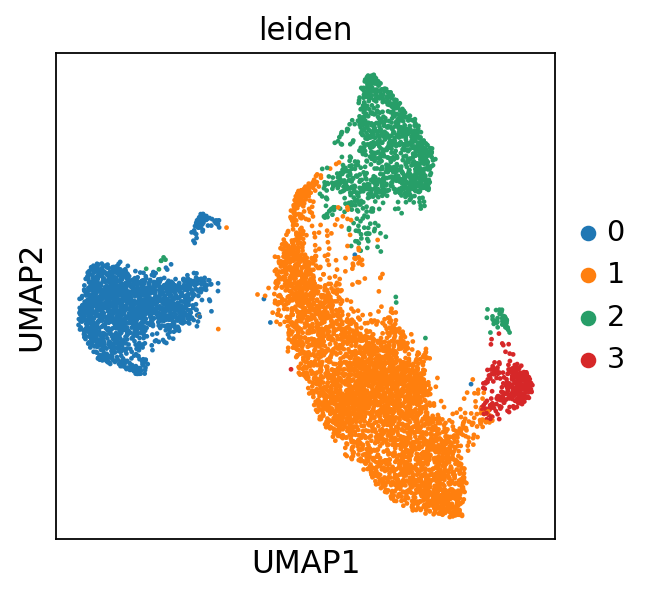

In [42]:
sc.pp.neighbors(mdata["gex"], n_neighbors = 50)
sc.tl.umap(mdata["gex"], min_dist=0.5, spread= 5.0)

sc.tl.leiden(mdata["gex"], resolution =0.2, n_iterations=-1, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])

running Leiden clustering
    finished (0:00:00)


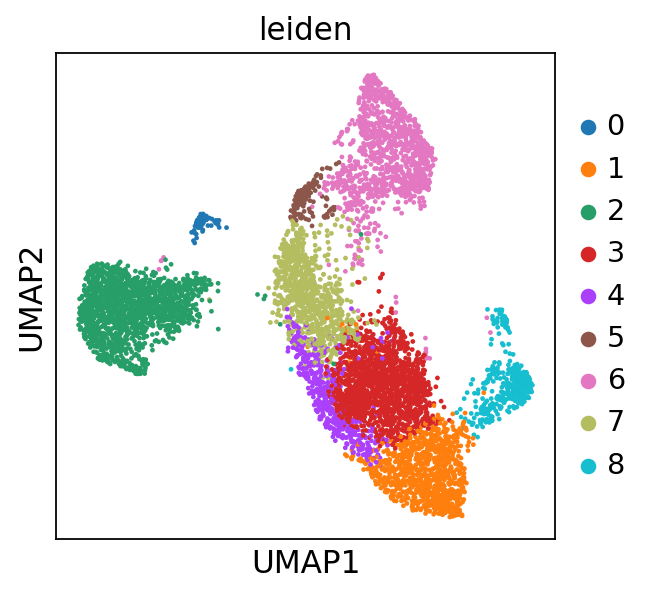

In [43]:
# sc.pp.neighbors(mdata["gex"], n_neighbors = 50)
# sc.tl.umap(mdata["gex"], min_dist=0.5, spread= 5.0)

sc.tl.leiden(mdata["gex"], resolution = 1, n_iterations=-1, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])

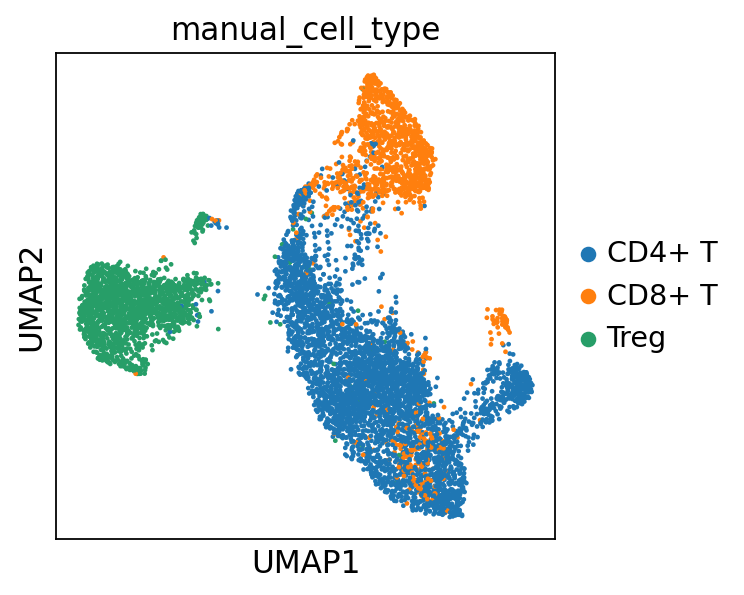

In [59]:
mdata["gex"].obs["manual_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()
sc.pl.umap(mdata["gex"], color=["manual_cell_type"])

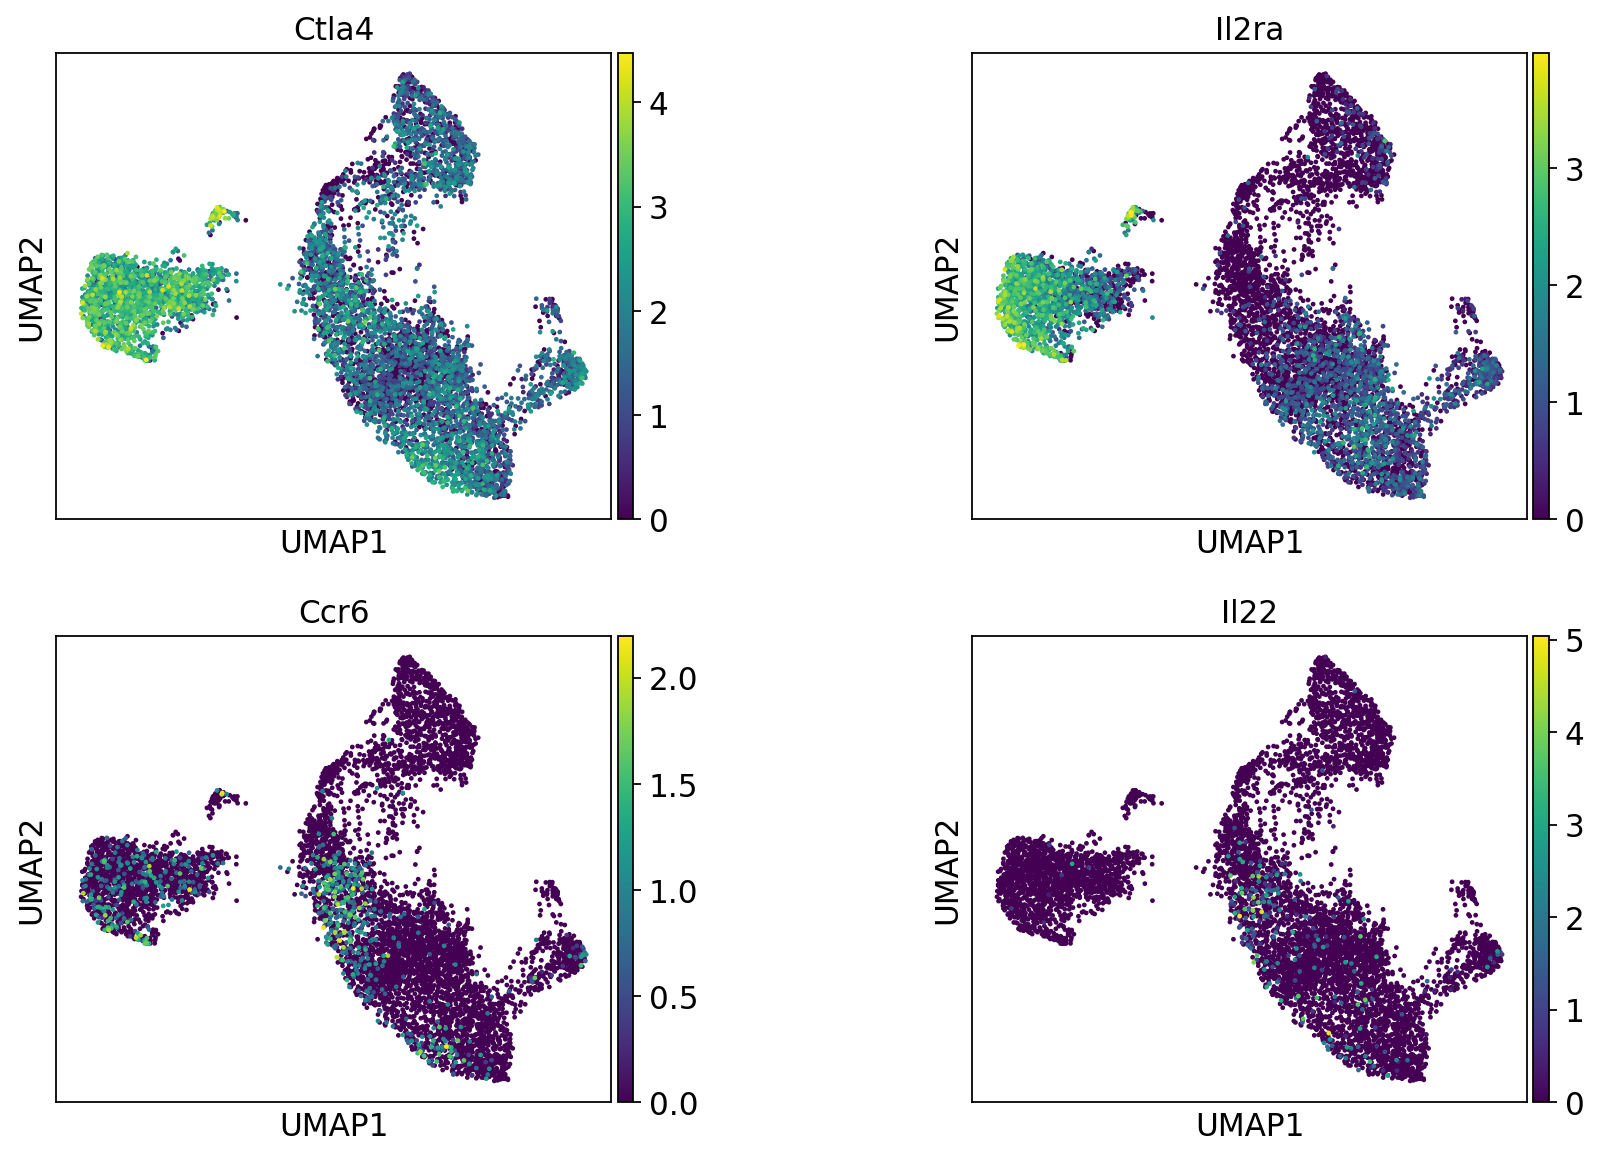

In [45]:
Th17_markers_Yutong = ['Ctla4', 'Il2ra','Ccr6', 'Il22']
Th17_markers = ['Rorc', 'Il17a', 'Il17f', 'Il23r', 'Ccr6', 'Itgae', 'Furin', 'Ctsh', "Il21", "Stat3", "Cd40lg"]
Kir_family = ['Klra6', 'Klra1', 'Klra3', 'Klra7']
markers_in = []
for i in Th17_markers_Yutong:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
markers_in

mu.pl.embedding(mdata["gex"], basis="umap", color= markers_in,  wspace = 0.5, ncols=2, vmin=0)

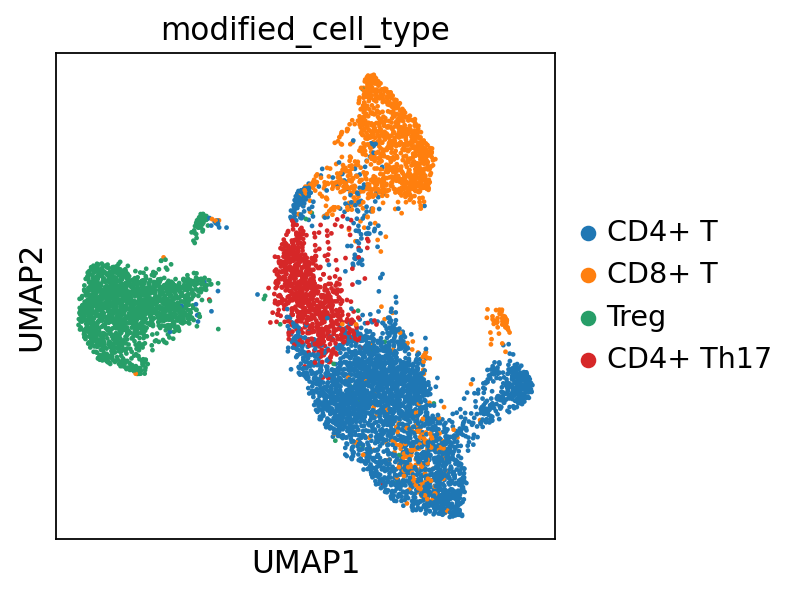

In [73]:
mdata["gex"].obs["modified_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()

mdata["gex"].obs['modified_cell_type'] = mdata["gex"].obs['modified_cell_type'].cat.add_categories(["CD4+ Th17"])
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['7'])] = 'CD4+ Th17'

# mdata["gex"].obs['manual_cell_type'][mdata["gex"].obs['leiden'].isin(['1','3'])] = 'CD4+ T'
# mdata["gex"].obs['manual_cell_type'][mdata["gex"].obs['leiden'].isin(['4','8'])] = 'CD8+ T'

mdata["gex"].obs['modified_cell_type'] = mdata["gex"].obs['modified_cell_type'].cat.remove_unused_categories()
sc.pl.umap(mdata["gex"], color=["modified_cell_type"])


In [74]:

# mdata["gex"].obs['manual_cell_type'] = mdata["gex"].obs['manual_cell_type'].cat.remove_unused_categories()
# # mdata.update()
# sc.pl.umap(mdata["gex"], color=["manual_cell_type"])


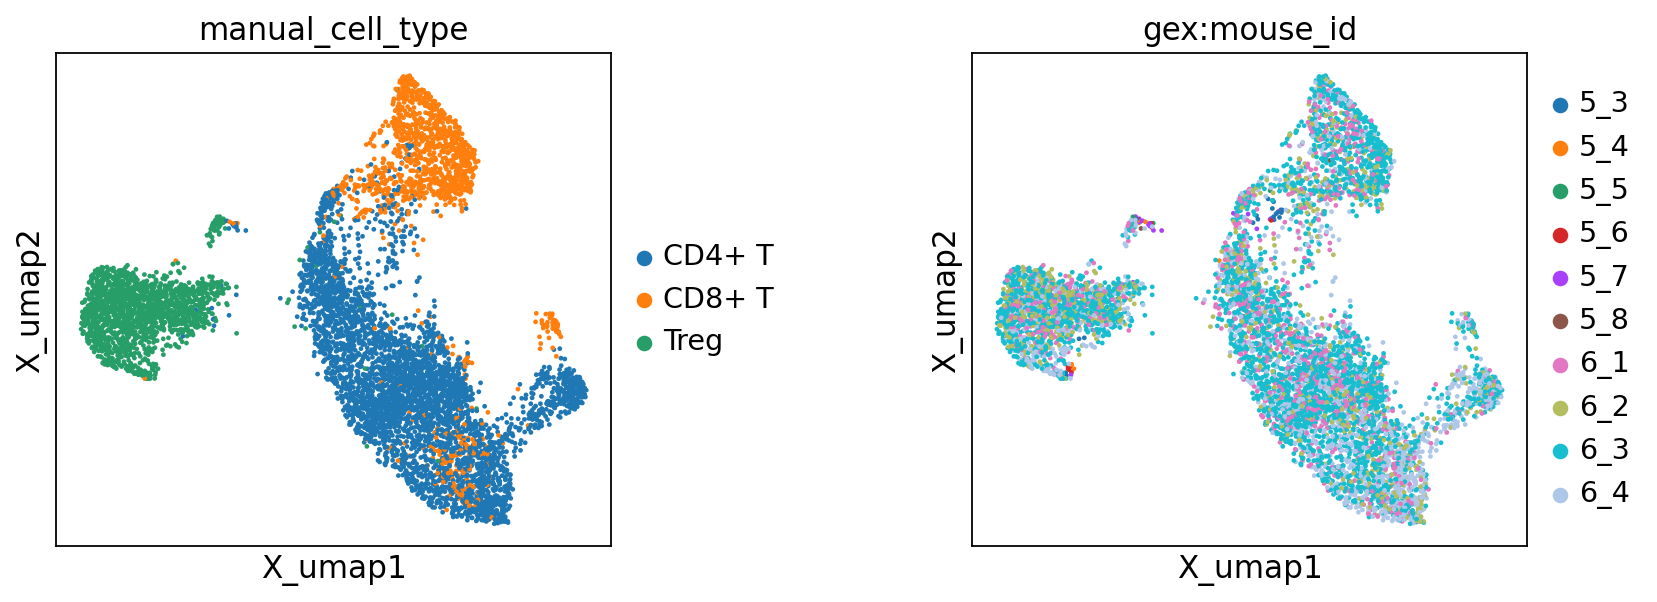

In [75]:
mdata.obs['manual_cell_type'] = mdata.obs['manual_cell_type'].cat.remove_unused_categories()
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type', 'gex:mouse_id'], wspace = 0.5)

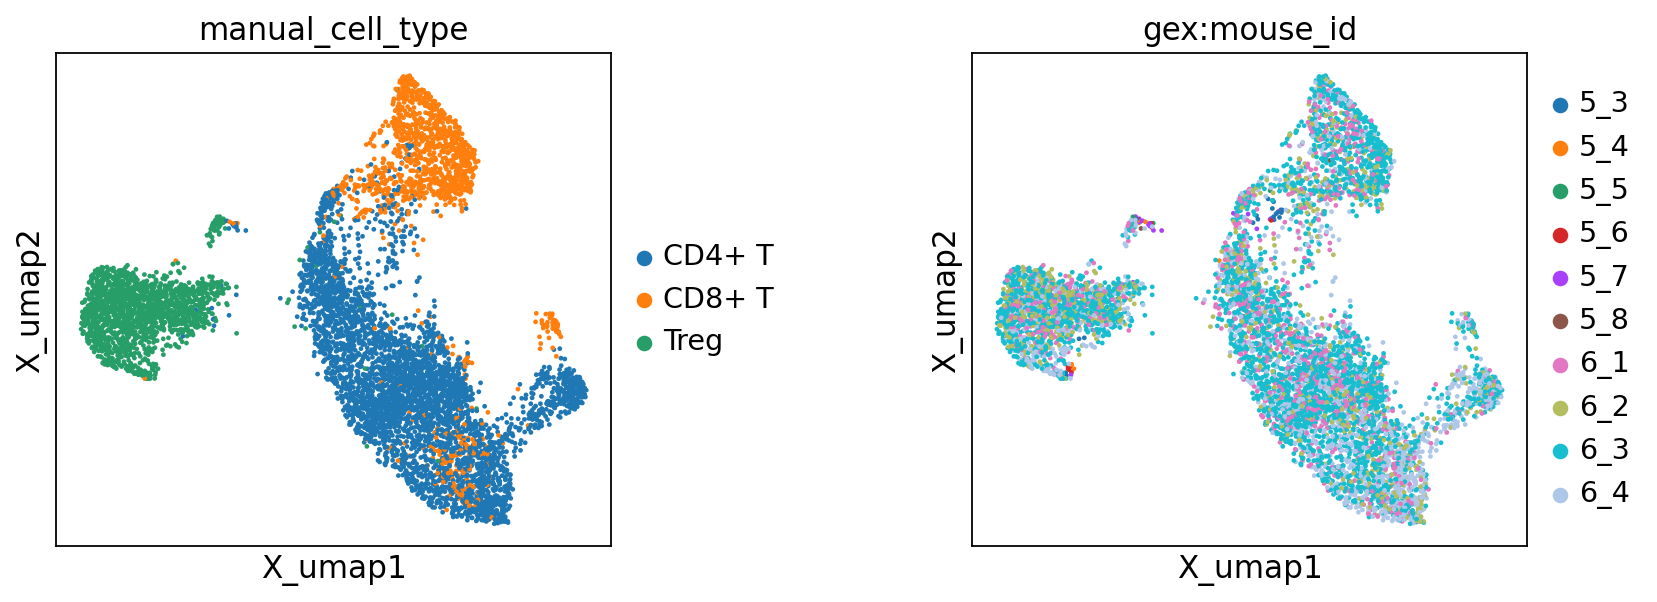

In [75]:
mdata.obs['manual_cell_type'] = mdata.obs['manual_cell_type'].cat.remove_unused_categories()
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type', 'gex:mouse_id'], wspace = 0.5)

In [76]:
# Merge the leiden clusters
# mdata["gex"].obs["merged_group"] = mdata["gex"].obs["leiden"]

# mdata["gex"].obs["merged_group"][mdata["gex"].obs["leiden"].isin(['1','2','6'])] = '1'
# mdata["gex"].obs["merged_group"][mdata["gex"].obs["leiden"].isin(['5','8','9'])] = '5'

# mdata["gex"].obs["merged_group"] = mdata["gex"].obs["merged_group"].cat.remove_unused_categories()

# sc.pl.umap(mdata["gex"], color=["merged_group"])

## cell state

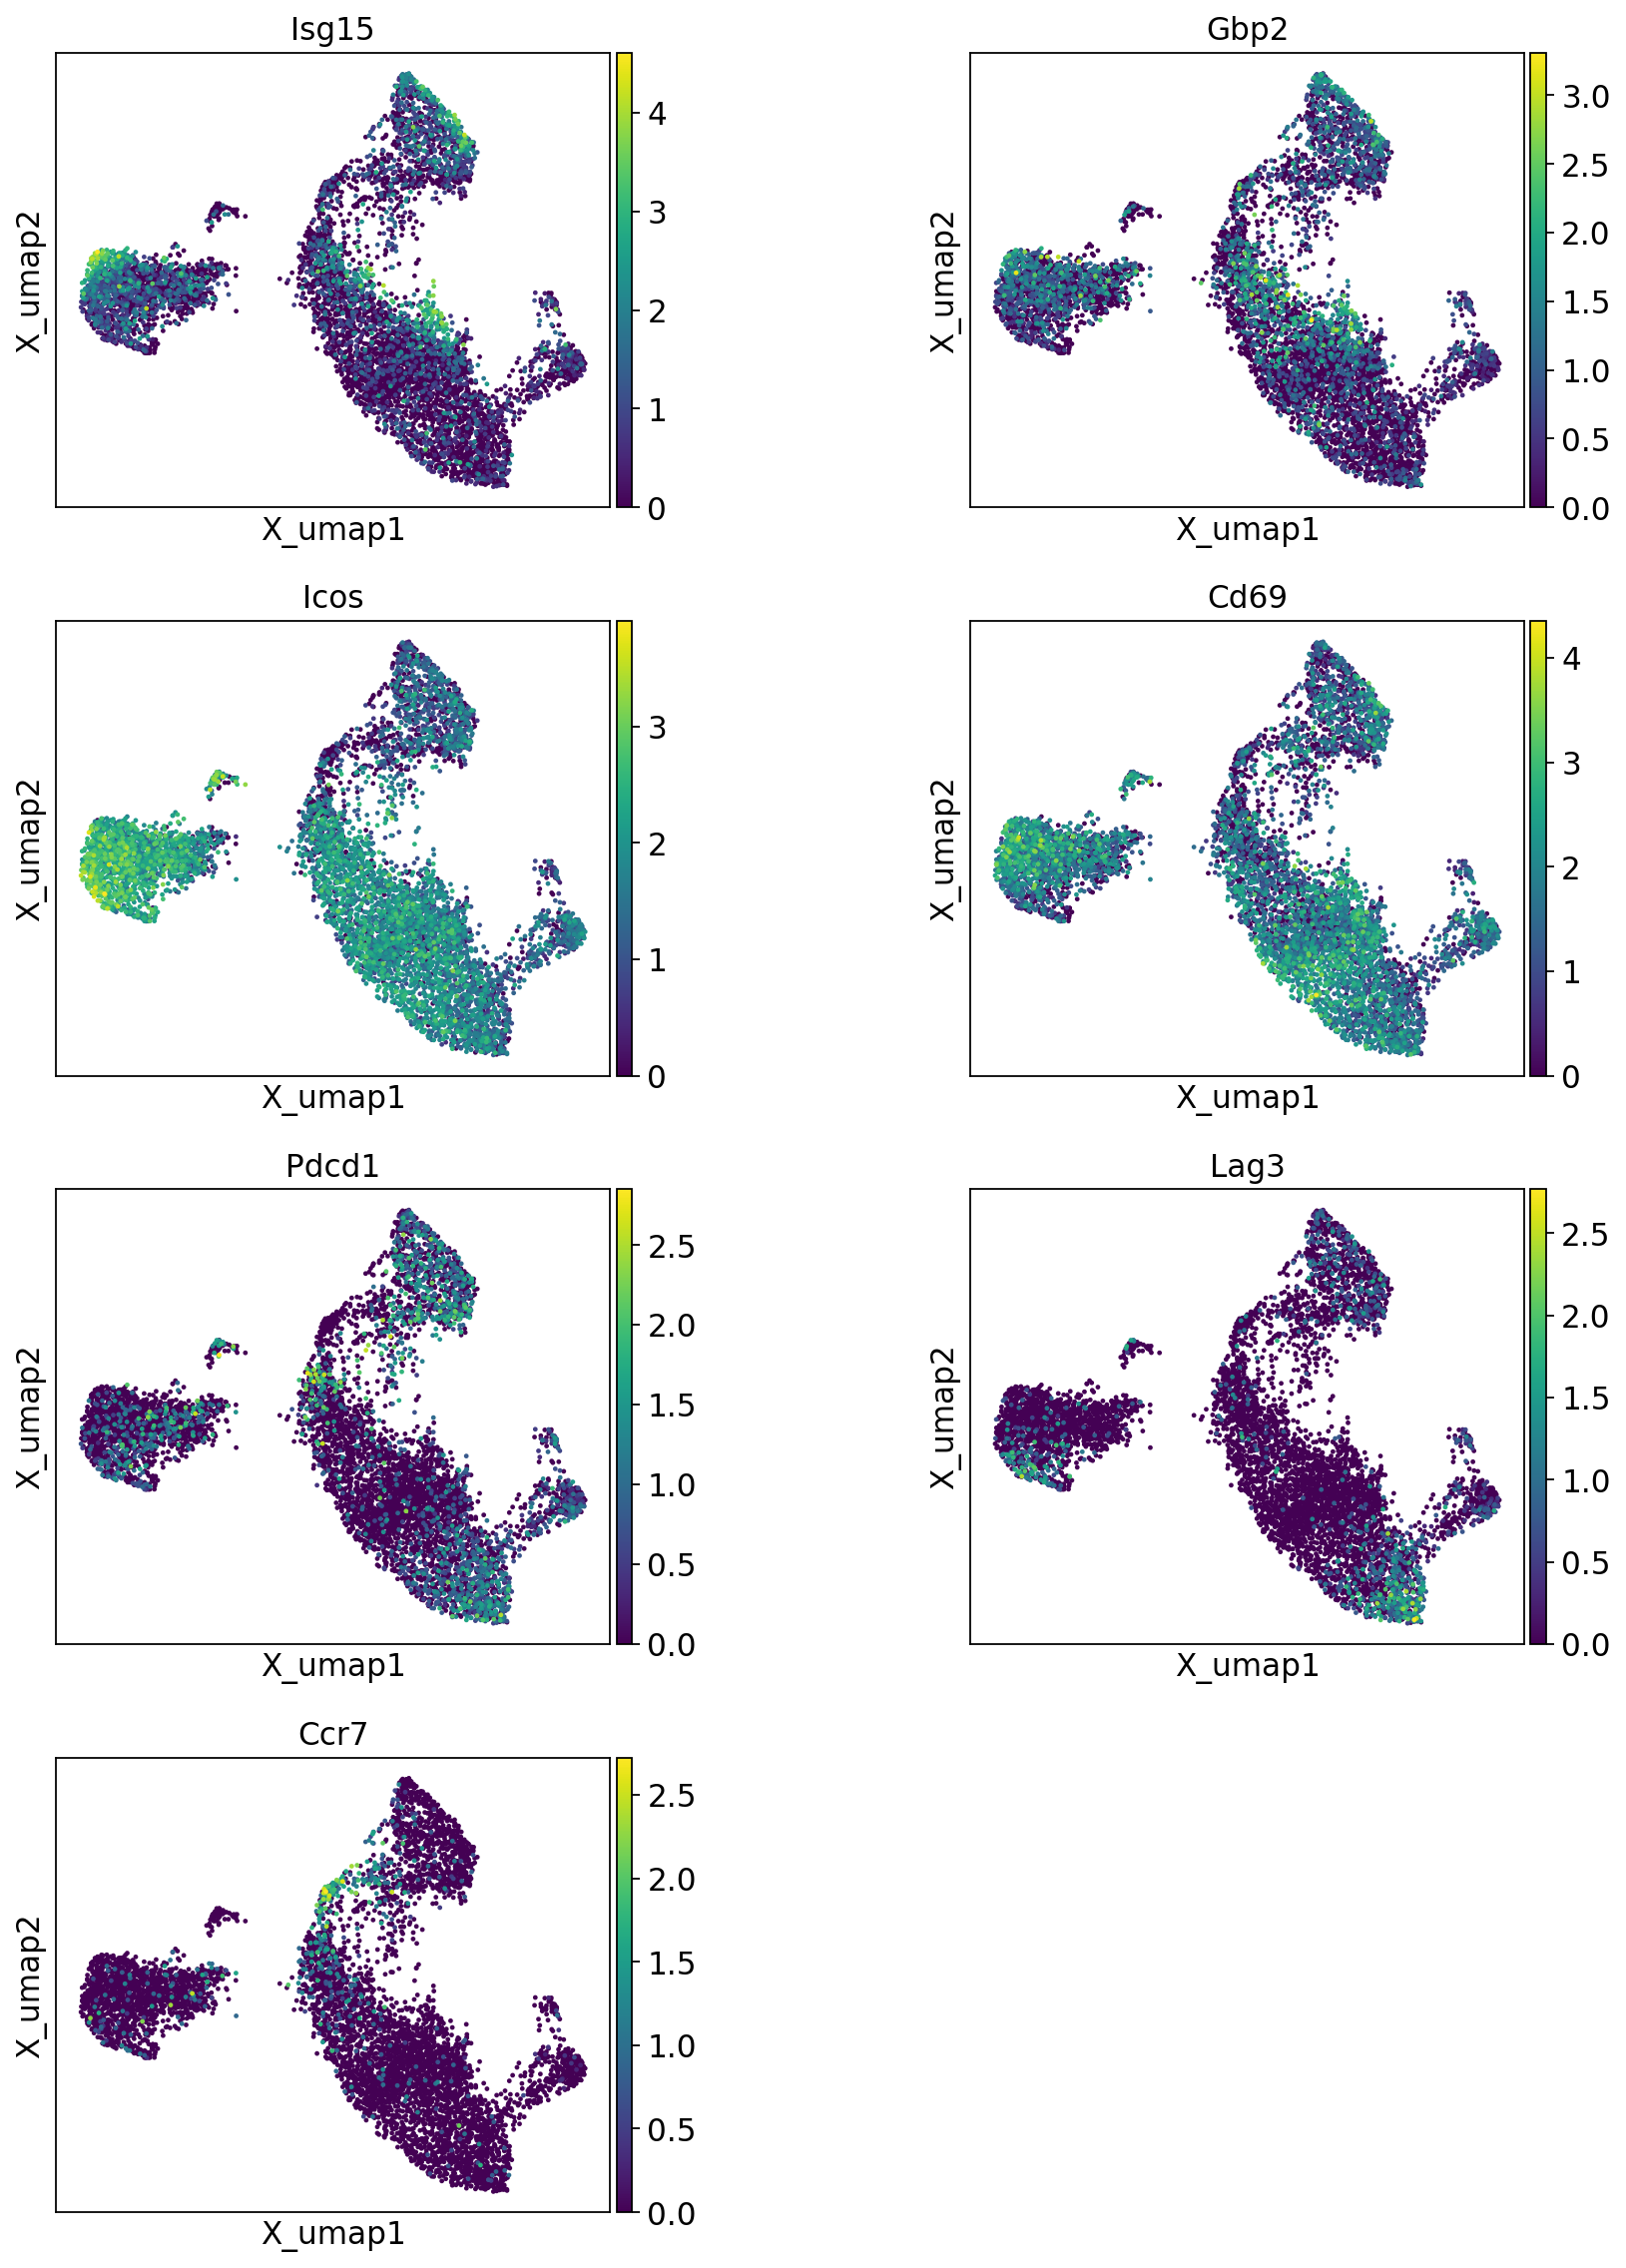

In [77]:
cell_state_Yutong = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Ccr7', 'Sell']
markers_in = []
for i in cell_state_Yutong:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
mu.pl.embedding(mdata, basis="gex:umap", color= markers_in, wspace = 0.5, ncols=2, vmin=0)

In [78]:
import scanpy as sc

IFN_stim = ['Isg15', 'Gbp2', 'Ifih1']
Activation = ['Icos', 'Cd69', 'Cd28']
Exhaust = ['Pdcd1', 'Lag3', 'Havcr2']
Mem = ['Ccr7', 'Sell', 'Cd27']

sc.tl.score_genes(mdata['gex'], gene_list=IFN_stim, score_name='IFN_stim')
sc.tl.score_genes(mdata['gex'], gene_list=Activation, score_name='Activation')
sc.tl.score_genes(mdata['gex'], gene_list=Exhaust, score_name='Exhaust')
sc.tl.score_genes(mdata['gex'], gene_list=Mem, score_name='Mem')


computing score 'IFN_stim'
    finished (0:00:00)
computing score 'Activation'
    finished (0:00:00)
computing score 'Exhaust'
    finished (0:00:00)
computing score 'Mem'
    finished (0:00:00)


In [79]:
mdata['gex'].obs['state'] = 'Effector'
mdata['gex'].obs.loc[mdata['gex'].obs['Exhaust'] > 0.5, 'state'] = 'Exhausted'
mdata['gex'].obs.loc[mdata['gex'].obs['Mem'] > 0.5, 'state'] = 'Mem'
mdata['gex'].obs.loc[mdata['gex'].obs['IFN_stim'] > 0.5, 'state'] = 'activated'
mdata['gex'].obs.loc[mdata['gex'].obs['Activation'] > 0.5, 'state'] = 'activated'


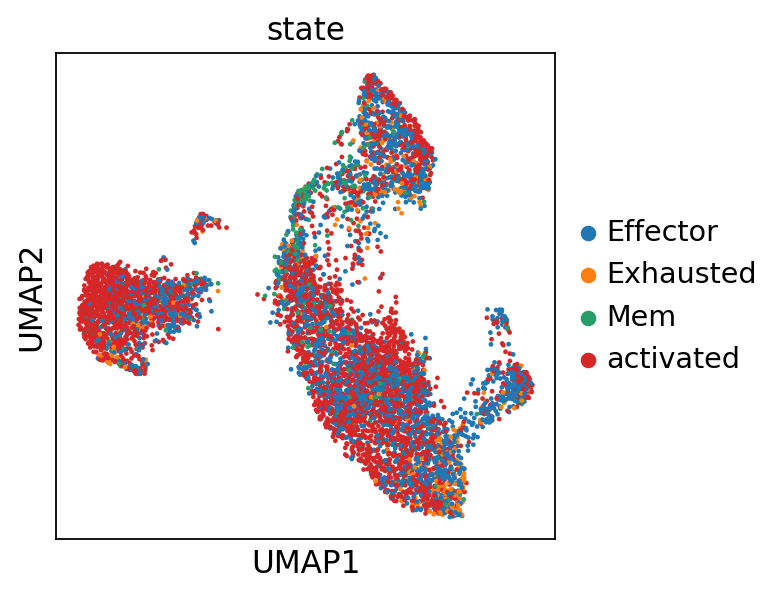

In [80]:
mu.pl.embedding(mdata['gex'], basis="umap", color='state', wspace = 0.5, ncols=2, vmin=0)

ranking genes
    finished (0:00:01)


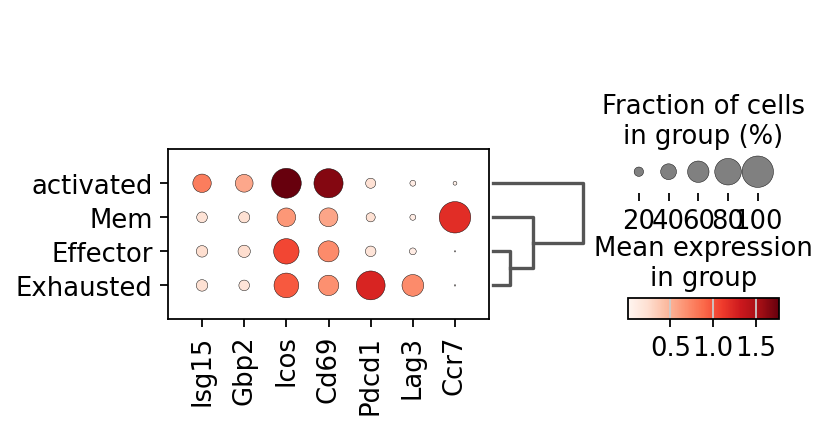

In [81]:
sc.tl.rank_genes_groups(
        mdata["gex"],
        "state",
        # groups = cell_state_Yutong,
        reference= "rest",
        method="wilcoxon"
    )

sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby ="state", 
                                   var_names=markers_in, )


In [82]:
%cd /ihome/ylee/yiz133/Code/Data processing

/ihome/ylee/yiz133/Code/Data processing


In [83]:
mdata.write("Annotated_CNS_DE2000.h5mu")

In [84]:
# states annotated by cluster (wrong)

# cluster_state = {
#     "0": "IFN stimulated",
#     "1": "IFN stimulated",
#     "5": "IFN stimulated",
#     "2": "Exhuasted",
#     "3": "Exhuasted",
#     "4": "Activated",
#     "7": "Activated",
#     "9": "Activated",
#     "6": "Activated",
#     "8": "Memory/Naive",    
# }

# mdata["gex"].obs["cell_state"] = mdata["gex"].obs["leiden"].map(cluster_state)
# sc.pl.umap(mdata["gex"], color=["leiden", "cell_state"])

# sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby ="cell_state", 
#                                    var_names=cell_state_Yutong, )

# END

In [85]:
aaa

NameError: name 'aaa' is not defined

# DEA among annotated cell types

In [ ]:
cell_types = ['CD4+ T', 'CD8+ T', 'Treg', 'CD4+ Th17']
mdata.obs['manual_cell_type'] = mdata["gex"].obs['manual_cell_type']

sc.tl.rank_genes_groups(
        mdata["gex"],
        "manual_cell_type",
        groups = cell_types,
        reference= "rest",
        method="wilcoxon"
    )

sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby ="manual_cell_type", 
                                   var_names=["Cd4", "Cd8a", "Cd8b1", "Nkg7","Foxp3", "Ikzf2", "Ctla4", "Il2ra", "Ccr6", "Il22"], )

In [ ]:
sc.pl.rank_genes_groups_heatmap(mdata["gex"], groupby ="manual_cell_type", n_genes=10, cmap='bwr')

In [ ]:
#### remove unormal genes ###
genes_to_remove = ['Tmsb4x', 'Actb', 'Rpl12', 'Rps7','Fth1', 'Left1']
mask = ~mdata["gex"].var_names.isin(genes_to_remove)
adata_filtered = mdata["gex"][:, mask].copy()


In [ ]:
sc.tl.rank_genes_groups(
        adata_filtered,
        "manual_cell_type",
        groups = cell_types,
        reference= "rest",
        method="wilcoxon",
    )

sc.pl.rank_genes_groups_heatmap(adata_filtered, groupby ="manual_cell_type", n_genes=10, cmap='bwr')

In [ ]:
#### violin plot  #####
# num_plots = len(cell_types)
# num_cols = 2  # Number of columns in the figure
# num_rows = int(np.ceil(num_plots / num_cols))  # Number of rows based on total clonotypes

# # Create subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 4))  
# axs = axs.flatten()  # Flatten in case of multiple rows

# # Generate violin plots for each clonotype
# for ct, ax in zip(cell_types, axs):
#     sc.pl.rank_genes_groups_violin(mdata["gex"], groups=[ct], n_genes=25, ax=ax, show=False, strip=False)

# # Remove any unused subplots
# for i in range(len(cell_types), len(axs)):
#     fig.delaxes(axs[i])

# plt.tight_layout()
# plt.show()
    

In [ ]:
# ir.pp.index_chains(mdata)
# ir.tl.chain_qc(mdata)

In [ ]:
# mu.pl.embedding(mdata, basis="gex:umap", color=['Cd4'], wspace = 0.5, ncols=2)

# DEA among clusters

In [ ]:
in_group = mdata["gex"].obs["leiden"]=='11'
# mdata = mdata[~in_group]
# in_group = mdata["gex"].obs["manual_cell_type"].isin(["CD4+ T","CD8+ T","Treg","CD4+ Th17"])
# mdata = mdata[in_group].copy()
              
# sc.tl.rank_genes_groups(mdata["gex"], groupby ="leiden", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby = "leiden",
                                # n_genes=10, 
                                var_names = cell_state_Yutong
                                )



In [ ]:
top_gene_leiden = mdata["gex"].uns['rank_genes_groups']['names'][0:20].tolist()
# 'scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'pts'
com_genes = pd.DataFrame(top_gene_leiden)
com_genes

In [ ]:
top_gene_leiden_score = mdata["gex"].uns['rank_genes_groups']['scores'][0:20].tolist()
com_genes_score = pd.DataFrame(top_gene_leiden_score)
com_genes_score

In [ ]:
leiden_clusters = ['0','7']

sc.tl.rank_genes_groups(mdata["gex"], groupby ="merged_group", reference = '4',
                        groups = leiden_clusters, method="wilcoxon")

num_clonotypes = len(leiden_clusters)
num_cols = 2  # Number of columns in the figure
num_rows = int(np.ceil(num_clonotypes / num_cols))  # Number of rows based on total clonotypes

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))  
axs = axs.flatten()  # Flatten in case of multiple rows

# Generate violin plots for each clonotype
for ct, ax in zip(leiden_clusters, axs):
    sc.pl.rank_genes_groups_violin(mdata["gex"], groups=[ct], n_genes=10, ax=ax, show=False, strip=False)

# Remove any unused subplots
for i in range(len(leiden_clusters), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

### DAE in mergerd groups

In [ ]:
merged_clusters = ['0','7']

# groups = merged_clusters,
sc.tl.rank_genes_groups(mdata["gex"], groupby = "merged_group")
    
sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby = "merged_group", n_genes=10)
# sc.pl.dotplot(mdata["gex"], groupby = "merged_group",  genes=10)

 # groupby = "merged_group", groups = merged_clusters,

In [ ]:
merged_clusters = ['0','7']
sc.tl.rank_genes_groups(mdata["gex"], groupby = "merged_group")
# groups = merged_clusters

sc.pl.rank_genes_groups_heatmap(mdata["gex"], groupby = "merged_group",
                                n_genes=5, cmap='bwr',)

In [ ]:
# logfold change
sc.pl.rank_genes_groups_matrixplot(mdata["gex"], groupby = "merged_group",
                                n_genes=10, cmap='bwr')

In [ ]:
a = mdata["gex"].uns['rank_genes_groups']['names'][0:20].tolist()
com_genes = pd.DataFrame(a)
# com_genes

In [ ]:
# sc.pl.dotplot(mdata["gex"], var_names=['Cd4', 'Runx1'], groupby='leiden')

### T cell subset markers

In [ ]:
target_genes = [gene for gene in mdata["gex"].var_names if gene.startswith("Lta")]
target_genes

In [ ]:
# markers for CD4+
# select from DEA

# set 1: human markers 
# <Reinvestigation of Classic T Cell Subsets and Identification of Novel Cell Subpopulations by Single-Cell RNA Sequencing>
# naive_markers = ['Ccr7', 'Lef1', "Sell"]
# cd4_mem_markers = ['Tnfrsf4', 'Timp1', "Usp10"]
# cd8_Eff_Mem_markers = ['Cd45ra', 'Fgfbp2', "Gzmh", "Gzmb"]
# Mait_markers = ["Klrb1", "Ncr3", "Zbtb16", 'Rorc']


# set 2: mouse markers
# <Single-Cell RNA Sequencing of the T Helper Cell Response to House Dust Mites Defines a Distinct Gene Expression Signature in Airway Th2 Cells>
Th2_markers = ['Gata3', 'Il13', "Il5", "Il1rl1", "Plac8", "Igfbp7"]
Th1_markers = ['Cxcr3', 'Ccl5', "Tbx21"]
Activated_markers = ['Tcf7', 'S1pr1', "Trat1", "Tmem176a"]
Treg_markers = ["Foxp3", "Ctla4", "Il10", "Klrg1", "Folr4", "Il2ra"]

sorting_marker = ["Cd3", "Cd4", "Cd44", "St2", "Cd25"]

In [ ]:
markers_in = []
for i in Activated_markers:
    if i in adata_filtered.var_names:
        markers_in.append(i) 

mu.pl.embedding(mdata, basis="gex:umap", color= markers_in, wspace = 0.5, ncols=2, vmin=0)

In [ ]:
# from top DAE
mu.pl.embedding(mdata, basis="gex:umap", color=com_genes.iloc[-4:-1,0], wspace = 0.5, ncols=2)

In [ ]:
# in_mem_cluster = mdata["gex"].obs["leiden"].isin([ "0", "1"])

# mdata.obs["manual_cell_type"][in_mem_cluster] = mdata.obs["manual_cell_type"] + "_mem"
# mdata.obs["manual_cell_type"][in_mem_cluster] = mdata.obs["manual_cell_type"][in_mem_cluster]+ "_mem"

# for i in range(len(mdata)):
#     if mdata.obs["manual_cell_type"][i][-4:] == "_mem":
#         mdata.obs["manual_cell_type"][i] = mdata.obs["manual_cell_type"][i][:-4]

In [ ]:
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type','gex:tissue'], wspace = 0.5)

In [ ]:
# another ploting commd
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
# mu.pl.embedding(mdata, basis="gex:umap", color=["Cd3e"], ax=ax0, show=False)
# mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

In [ ]:
# mdata.write("0605_SPL_Clustered_GEX_Top2000.h5mu")

# subset in CD4

In [ ]:
 # mdata[mdata.mod["gex"].obs["tissue"].isin(["SP"]) ]

In [ ]:
cd4_set = mdata[mdata.obs["manual_cell_type"].isin(["CD4+ T", "CD4+ T_mem"])]

In [ ]:
cd4_set.obs["manual_cell_type"].value_counts()

In [ ]:
sc.pp.pca(cd4_set["gex"], svd_solver="arpack", n_comps=20)

In [ ]:
sc.pp.neighbors(cd4_set["gex"], n_neighbors = 20)
sc.tl.umap(cd4_set["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(cd4_set["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(cd4_set["gex"], color=["leiden", "manual_cell_type"])

In [ ]:
# sc.pp.neighbors(cd4_set["gex"], n_neighbors = 50)
# sc.tl.umap(cd4_set["gex"], min_dist=0.5, spread=5.0)
# sc.tl.leiden(cd4_set["gex"], resolution = 1, n_iterations= -1, flavor = 'igraph')
# sc.pl.umap(cd4_set["gex"], color=["leiden", "manual_cell_type"])


In [ ]:
# leiden_groups = list(set(cd4_set["gex"].obs["leiden"])
L = int(max(cd4_set["gex"].obs['leiden']))
leiden_groups = [str(x) for x in range(L+1)]

sc.tl.rank_genes_groups(
        cd4_set["gex"],
        "leiden",
        groups = leiden_groups,
        reference= "rest",
        method="wilcoxon"
    )

In [ ]:
# Dynamically determine the number of rows/columns for subplots
sc.tl.dendrogram(cd4_set["gex"], groupby='leiden',)
sc.pl.rank_genes_groups_matrixplot(cd4_set["gex"], groupby='leiden', n_genes=10, cmap='bwr')

In [ ]:
target_genes = [gene for gene in cd4_set["gex"].var_names if gene.startswith("Tbx21")]
target_genes

In [ ]:
# set 1: human markers
# <Current annotation strategies for T cell phenotyping of single-cell RNA-seq data>
# Th1_markers = ['Ccl5', 'Ccr1', 'Cxcr3', 'Tnfa', 'Cd3', 'Il2']
# Th2_markers = ['Cd3', 'Ccr3', 'Ccr8', 'Gata3', 'Il5', 'Il4']
# Th17_markers = ['Il17a', 'Il17f', 'Il17', 'Il7r', 'Il5', 'Il4']
# cd4_markers = ['Ly6a', 'Cd40lg']

# set 2: mouse markers
# <Single-Cell RNA Sequencing of the T Helper Cell Response to House Dust Mites Defines a Distinct Gene Expression Signature in Airway Th2 Cells>
Th1_markers = ['Tbx21', 'Ccl5', 'Cxcr3', 'Ifng', 'Gzmk', "Il2", "Lta", "Tnf", 'Il12rb2']
# not exclusive genes: 'Stat4', 'Stat1', 'Ms4a4b', 
Th2_markers = ['Gata3', 'Il13', 'Il1rl1', 'Plac8', 'Il5', 'Igfbp7', "Il4", "Ccr4", "Ccl17", "Stat6"]
activated_markers = ['Tcf7', 'S1pr1', 'Trat1', 'Klf2', 'Tmem176a', 'Tmem176b']
Treg_markers = ['Foxp3', 'Ctla4', 'Il2ra', "Ikzf2", 'Il10', 'Klrg1',  'Folr4', "Cd39"]
Th17_markers = ['Rorc', 'Il17a', 'Il17f', 'Il23r', 'Ccr6', 'Itgae', 'Furin', 'Ctsh', "Il21", "Stat3", "Cd40lg"]

#


In [ ]:
markers_in = []
for i in Th2_markers:
    if i in cd4_set["gex"].var_names:
        markers_in.append(i) 
markers_in

mu.pl.embedding(cd4_set["gex"], basis="umap", color= markers_in,  wspace = 0.5, ncols=2, vmin=0)

In [ ]:
top_gene_by_type = cd4_set["gex"].uns['rank_genes_groups']['names'][0:20].tolist()
com_genes = pd.DataFrame(top_gene_by_type)
com_genes

# keep subsetting

In [ ]:
cd4_subset1 = cd4_set["gex"][cd4_set["gex"].obs["leiden"].isin(["0","1","4"])]

In [ ]:
sc.pp.pca(cd4_subset1, svd_solver="arpack", n_comps=20)

In [ ]:
sc.pp.neighbors(cd4_subset1, n_neighbors = 20)
sc.tl.umap(cd4_subset1, min_dist=0.2, spread=2.0)
sc.tl.leiden(cd4_subset1, resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(cd4_subset1, color=["leiden", "manual_cell_type"])

In [ ]:
markers_in = []
for i in Treg_markers:
    if i in cd4_subset1.var_names:
        markers_in.append(i) 
markers_in

mu.pl.embedding(cd4_subset1, basis="umap", color= markers_in,  wspace = 0.5, ncols=2)

## compare with ref set

In [ ]:
cluster_data = []
# 'pvals_adj', 'pts'

top_L = 100
topGene_names = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['names'][0:top_L].tolist())
topGene_scores = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['scores'][0:top_L].tolist())
topGene_LF = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['logfoldchanges'][0:top_L].tolist())
topGene_pvals = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['pvals'][0:top_L].tolist())

metrics = ['gene', 'scores', 'avg_logFC', 'pvals']
metrics_df = [topGene_names, topGene_pvals, topGene_scores, topGene_LF]

clusters_list = []
for i in range(L+1):
    cluster_dict = {}
    for j in range(len(metrics)):
        cluster_dict[metrics[j]] = metrics_df[j].iloc[:,i]
    clusters_list.append(cluster_dict)


In [ ]:
%cd ../../../Data processing/data/ref_snRNA/1

In [ ]:
import pickle
with open('Cd4_p.pkl', 'rb') as file:
    cluster_metric_ref = pickle.load(file)
metric_selected = 'avg_logFC'
ref_types = len(cluster_metric_ref)

# cluster_metric_ref = pd.read_csv('Th17.csv')
# metric_selected = 'effect_size'
# ref_types = 1

In [ ]:
# intersect genes
corr_mat = np.zeros([L+1, ref_types])
common_gene_num = np.zeros([L+1, ref_types])

common_genes_L = []

for i in range(L+1):
    for j in range(ref_types):
        
        # multi tab
        ref_cluster = cluster_metric_ref[str(j+1)].loc[:, [metric_selected, 'gene']]
        # 'gene', 'scores', 'avg_logFC', 'pvals']
        
        # single tab
        # ref_cluster = cluster_metric_ref.loc[:, [metric_selected, 'gene']]
        
        n_genes = min(top_L, len(ref_cluster))
        ref_cluster = ref_cluster.sort_values(by= metric_selected, ascending=False)
        ref_cluster = ref_cluster.iloc[:n_genes]

        c1 = pd.DataFrame(clusters_list[i]).iloc[:n_genes, [0,2]]
        c2 = pd.DataFrame(ref_cluster)
        
        common_genes = pd.merge(c1, c2, on='gene', how='inner')
        corr_mat[i][j] = common_genes.iloc[:,1].corr(common_genes.iloc[:,2], method='kendall')
        common_gene_num[i][j] = len(common_genes)
        
        common_genes_L.append(common_genes)
    
pd.DataFrame(corr_mat)

In [ ]:
markers_in = common_genes_L[0]['gene'].to_list()
mu.pl.embedding(cd4_set["gex"], basis="umap", color= markers_in, wspace = 0.5, ncols=2)

In [ ]:
common_genes_L[0]

In [ ]:
common_genes_L[4]

In [ ]:
# top_gene_all = cd4_set["gex"].uns['rank_genes_groups']['names'].tolist()
# top_gene_all_df = pd.DataFrame(top_gene_all)

# search_gene = "Ccl5"
# mask = top_gene_all_df.isin([search_gene])

# matching_indices = top_gene_all_df.index[mask.any(axis=1)].tolist()

# print(matching_indices)

# batch effect


In [ ]:
mdata_ori = mu.read("common_GEX_TCR_QC_mdata.h5mu")
mdata_ori

In [ ]:
# exclude 2D2 transfer samples

selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325", "CMO323"]
selected_date = ["0516"]
selected_tissue = ["CN"]

mdata = mdata_ori[~ (mdata_ori.mod["gex"].obs["mouse_id"].isin(selected_samples_id) & mdata_ori.mod["gex"].obs["date"].isin(selected_date))]

# positive select
# mdata = mdata[mdata.mod["gex"].obs["sample"].isin(["SPL_0605"]) ]
mdata

In [ ]:
# mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
# mdata.obs["manual_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()
# mdata.obs["celltype_sample"] = (
#     mdata.obs["manual_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
# )

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(8,8))
# mu.pl.embedding(mdata_ori, basis="gex:umap", ax=ax0)

mask = mdata_ori['gex'].obs['tissue'] == 'SP'

mu.pl.embedding(mdata_ori, basis="gex:umap", color=['gex:mouse_id'], mask_obs=mask, ax=ax0)

In [ ]:
mdata["gex"].obs["mouse_id"].value_counts()

In [ ]:
import bbknn
bbknn.bbknn(mdata["gex"], batch_key="mouse_id", use_annoy=False)

In [ ]:
sc.tl.umap(mdata["gex"])

In [ ]:
mu.pl.embedding(mdata, basis="gex:X_umap", color = ["gex:mouse_id", "manual_cell_type"], wspace = 0.5)


In [ ]:
# alternative plot commmand


# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"wspace": 1})
# sc.pl.umap(mdata["gex"], color=["mouse_id"])
# mdata["gex"].obs["manual_cell_type"] = mdata.obs["manual_cell_type"]

# sc.pl.umap(mdata["gex"], color=["manual_cell_type"])


In [ ]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(mdata["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])

In [ ]:
mdata["gex"].obs["leiden"]

# Save Filtered TCR table

In [ ]:
mdata = mu.read("common_GEX_TCR_mdata.h5mu")
mdata

In [ ]:
adata_tcr = mdata.mod['airr']
adata_tcr.obsm["airr"][0]

In [ ]:
meta_DF = ir.get.airr(adata_tcr, ["cdr3_aa", "consensus_count", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))

# , "high_confidence","productive"

# ('VJ_1', 'VDJ_1', 'VJ_2', 'VDJ_2'), 

meta_DF.iloc[0:10,:]

In [ ]:
meta_DF["VDJ_1_j_call"].value_counts()

In [ ]:
# meta_DF.to_csv('primary_TCR.csv', index=True)